In [3]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import pickle
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('once')

In [4]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/'

<font color ='green'><font size = 6> preliminary distribution

In [5]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 72701 # with _rf, the size of broken file is 266K instead of 0! 

    zenith_reco_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:] * lifetime/n_file


with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 18989

    zenith_reco_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]

    ### astrophysical ###
    energy = f.root.MCPrimary.cols.energy[:]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2813559.84254, 2955469.73138, 3052686.52963, 3240653.63454, 2919677.64478]  # _gaps.txt; 2012, 2013, 2014, 2015, 2016
    
    zenith_reco_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_reco_data_burn))

NoSuchNodeError: group ``/`` does not have a child named ``SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon``

In [ ]:
# ----- transform phase space ----- 
plt.rcParams.update({'font.size': 19})
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(19,8))
plt.subplot(121)
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.001)
plt.colorbar()

# near region 
p1 = 5.47 # y center
p2 = 0.9
p3 = 1.1 # x center
p4 = 0.7

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.1,2,0.2)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'--',color='darkorange')

# far region 
p1 = 5.47 # y center
p2 = 1.2
p3 = 1.1 # x center
p4 = 0.68

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.5,3,0.4)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'-',color='darkorange')

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.1,1,10,30,50,100,200,300,400,500,1000],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.title('CORSIKA+numu')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.savefig(fig_dir + 'rf_contour_uncut.png',dpi=600)

plt.subplot(122)
# data
plt.rcParams.update({'font.size': 19})
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

h_,yy_,xx_,img_ = plt.hist2d(np.cos(zenith_reco_data_burn), np.log10(truncated_muon_e_data_burn),cmap=my_cmap,
    bins=100,range=[[0,1],[5.5,8]],weights=weight_data_burn,vmin = 0.001)
plt.colorbar()

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.1,1,10,30,50,100,200,300,400,500,1000],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.title('burn sample')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
# plt.savefig(fig_dir + 'rf_contour_uncut.png',dpi=600)

plt.show()

<font color ='darkorange'><font size = 6> 1) Ineff < 0.01

In [ ]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:

    chi2_red_data_burn = (f.root.Collection.cols.chi2[:]/f.root.Collection.cols.NDF[:])
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:]      
    truncated_muon_e_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    zenith_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    closest_d_data_burn = f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:]
    passed_2 = (f.root.IT_veto_flag_window_2.cols.value[:]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 

In [6]:
" ----- IT ineff from data -----"
n_ = 100
emax = 8
e_spacing = (emax-5.5)/n_
d_spacing = (2500)/n_

Dist = []
Energy = []
Ineff_2 = []

for energy in np.linspace(5.5,emax,n_): # in each energy range [e1,e2]
    for dist in np.linspace(0,2500,n_): # in each dist range
        # energy cut  

        CUT_energy = (truncated_muon_e_data_burn>10**energy)&(truncated_muon_e_data_burn<10**(energy+e_spacing))
        CUT_dist = (closest_d_data_burn>dist)&(closest_d_data_burn<(dist+d_spacing))
        CUT = CUT_energy & CUT_dist

        closest_d_binned = closest_d_data_burn[CUT]
        passed_2_binned = passed_2[CUT] # events that pass the veto (not rejected)
        total_events_in_Bin = len(closest_d_binned[:]) # total events in this current bin

        Ineff_2 = np.append(Ineff_2, np.sum(passed_2_binned)/total_events_in_Bin ) # fraction of events pass veto in this distance bin

        Dist = np.append(Dist, dist)
        Energy = np.append(Energy,energy)

plt.figure(figsize=(7,6))
h,yy,xx,img=plt.hist2d(Dist,Energy,bins=[n_,n_],weights=Ineff_2,cmap=my_cmap,vmin=0.0) # ,range=[[0,2500],[5.5,emax]],range=[[0,2500],[5.5,emax]],bins=[n_,n_],
plt.colorbar()
CS=plt.contour(h.transpose(),extent=[0,2500,5.5,emax],lw=1,levels=[0.2,0.4,0.6,0.8])
plt.clabel(CS,inline=1,fmt='%1.1f',fontsize=10)
plt.clim(0,1)

# -- ineff low stat cut --
t = np.arange(0,2500,1)
plt.plot(t, 5.4+1.9*np.sqrt(1 - (t)**2/2300**2),color='r')
plt.axvline(2200,color='r')
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,2500)
plt.ylim(5.5,emax)
plt.title('IT Ineff from data, 2 pulses')
plt.show()

NameError: name 'truncated_muon_e_data_burn' is not defined

In [65]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # E: log10 of energy!!! 

    a = params[0] + params[2] * (E + params[1])**2 
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    
    val[val < 0.001] = 0.001 # This is arbitrary! 

    # low stat cut 
    val[E > 5.4+1.9*np.sqrt(1 - (dist)**2/2300**2)]=0.5
    val[dist>2200]=0.5
    return val

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


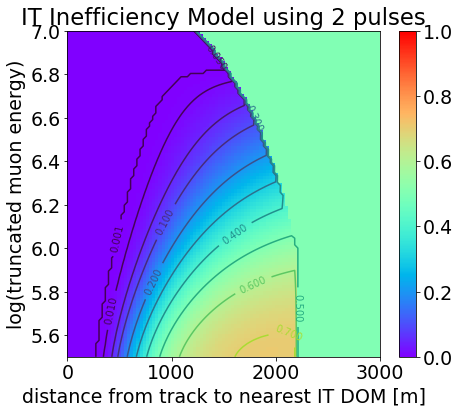

In [66]:
xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model(xg,yg)

plt.figure(figsize=(7,6))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('IT Inefficiency Model using 2 pulses')
plt.show()

In [67]:
IT_ineff_cut = 0.01

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 72701 # with _rf, the size of broken file is 266K instead of 0! 
    
    ineff_corsika = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut
    CUT_phase = (np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:])-0.95)**2/0.03**2+\
                (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    CUT = CUT_ineff & CUT_phase
#     CUT = CUT_ineff

    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    ndf_corsika = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_corsika = chi2_corsika/ndf_corsika
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_corsika = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]

    ineff_corsika = ineff_corsika[CUT]
    dist_corsika = f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:][CUT]
    weight_corsika = ineff_corsika * f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file # MODIFIED! 


with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 18989

    ineff_numu = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_numu < IT_ineff_cut
    CUT_phase = (np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:])-0.95)**2/0.03**2+\
                (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    CUT = CUT_ineff & CUT_phase
#     CUT = CUT_ineff

    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    ndf_numu = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_numu = chi2_numu/ndf_numu    
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_numu = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    ineff_numu = ineff_numu[CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()


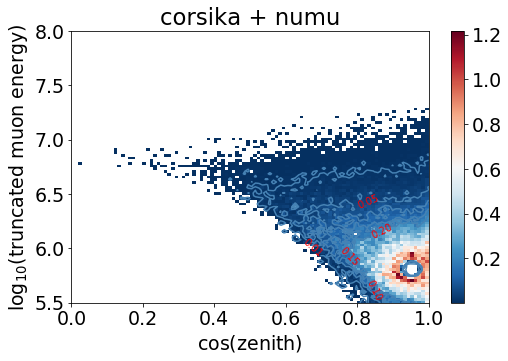

In [30]:
# ----- transform phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(8,5))
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.001)
plt.colorbar()

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.05,0.1,0.15,0.2],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.title('corsika + numu')
plt.savefig(fig_dir + 'rf_contour_small_ineff.pdf',bbox_inches='tight')
plt.savefig(fig_dir + 'rf_contour_small_ineff.png',dpi=300,bbox_inches='tight')
plt.show()

In [22]:
pcut1 = 5.82 # y center
pcut2 = 0.08
pcut3 = 0.95 # x center
pcut4 = 0.03

In [23]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),8  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((chi2_red_corsika,chi2_red_numu))
X[:,1] = np.concatenate((np.log10(PeakOverMedian_corsika),np.log10(PeakOverMedian_numu))) 
X[:,2] = np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu)))
X[:,3] = np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu)))
X[:,4] = np.concatenate(( (np.log10(truncated_muon_e_corsika)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_corsika)-pcut3)**2/pcut4**2,
                          (np.log10(truncated_muon_e_numu)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_numu)-pcut3)**2/pcut4**2  ))

X[:,5] = np.concatenate((signal_dnn_corsika,signal_dnn_numu))
X[:,6] = np.concatenate((ineff_corsika,ineff_numu))

X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5,random_state=1)
weights_train = X_train[:,-1] * 2
weights_test = X_test[:,-1] * 2
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
clf = RandomForestClassifier(n_estimators=500,n_jobs=8)

clf.fit(X_train, y_train)
# _ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/small_ineff_region.pkl', compress = 9)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


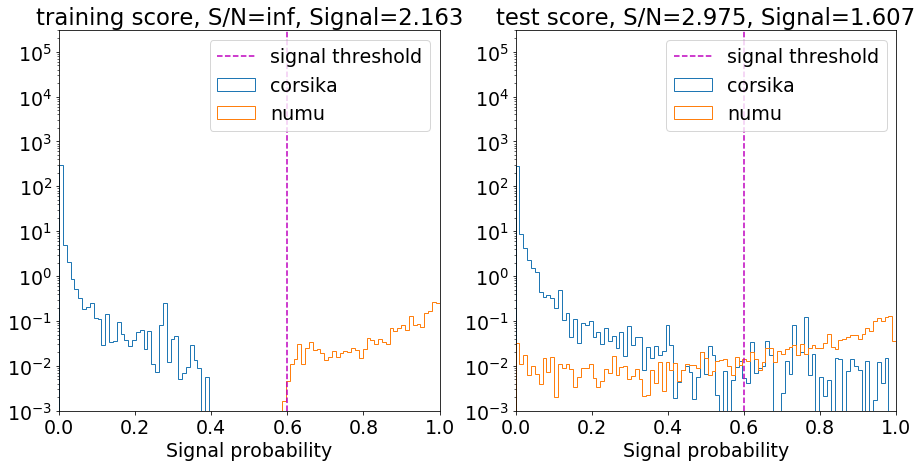

In [50]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

In [71]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2813559.84254, 2955469.73138, 3052686.52963, 3240653.63454, 2919677.64478]  # _gaps.txt; 2012, 2013, 2014, 2015, 2016

    ineff_data = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data < IT_ineff_cut
    CUT_veto = (f.root.IT_veto_flag_window_2.cols.value[:]).astype(bool) # data passed veto 
    CUT_phase = (np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:])-0.95)**2/0.03**2+\
                (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    CUT = CUT_ineff & CUT_veto & CUT_phase
    
    chi2_red_data_burn = (f.root.Collection.cols.chi2[:][CUT]/f.root.Collection.cols.NDF[:][CUT])
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]      
    truncated_muon_e_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    zenith_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    closest_d_data_burn = f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:][CUT]
    signal_dnn_data_burn = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    passed_2 = (f.root.IT_veto_flag_window_2.cols.value[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    ineff_data = ineff_data[CUT]
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(chi2_red_data_burn))


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [72]:
# rf classification for untagged data 

X = np.zeros((  len(chi2_red_data_burn),7 ))

X[:,0] = chi2_red_data_burn
X[:,1] = np.log10(PeakOverMedian_data_burn)
X[:,2] = np.cos(zenith_data_burn)
X[:,3] = np.log10(truncated_muon_e_data_burn)
X[:,4] = (np.log10(truncated_muon_e_data_burn)-pcut1)**2/pcut2**2+(np.cos(zenith_data_burn)-pcut3)**2/pcut4**2
X[:,5] = signal_dnn_data_burn
X[:,6] = ineff_data

probability_data = clf.predict_proba(X)[:,1]

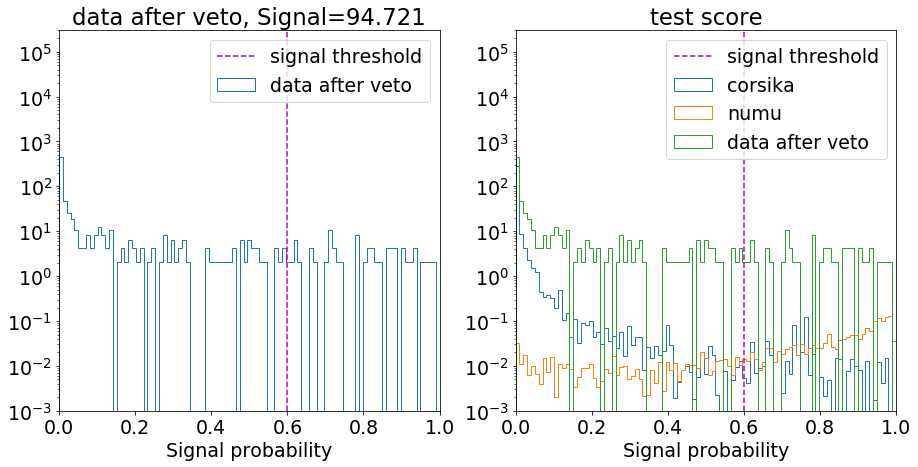

In [73]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_data,weights=weight_data_burn,bins=np.linspace(0,1,100),histtype='step',label='data after veto',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('data after veto, Signal='+str(np.round(np.sum(weight_data_burn[probability_data>0.6]),3)))
plt.legend()
plt.savefig(fig_dir + 'rf_apply_rf_to_data.pdf')


probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
h,b,p=plt.hist(probability_data,weights=weight_data_burn,bins=np.linspace(0,1,100),histtype='step',label='data after veto',log=True,bottom=10**(-6))
# plt.plot(b[1:],h,'.',color='black')
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score')
plt.legend()
plt.xlabel('Signal probability')
plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

In [74]:
# ------ background evaluation ------ # 

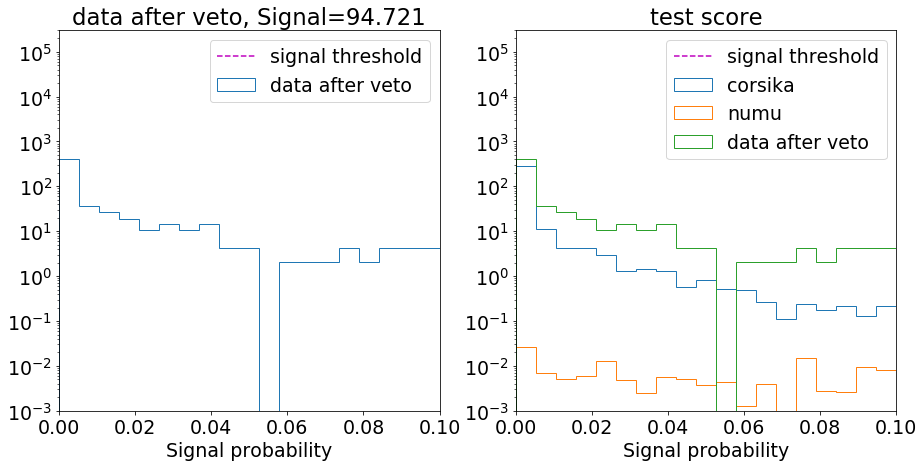

In [75]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_data,weights=weight_data_burn,bins=np.linspace(0,0.1,20),histtype='step',label='data after veto',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,0.1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('data after veto, Signal='+str(np.round(np.sum(weight_data_burn[probability_data>0.6]),3)))
plt.legend()
plt.savefig(fig_dir + 'rf_apply_rf_to_data.pdf')


probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,0.1,20),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,0.1,20),histtype='step',label='numu',log=True,bottom=10**(-6))
h,b,p=plt.hist(probability_data,weights=weight_data_burn,bins=np.linspace(0,0.1,20),histtype='step',label='data after veto',log=True,bottom=10**(-6))
# plt.plot(b[1:],h,'.',color='black')
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,0.1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score')
plt.legend()
plt.xlabel('Signal probability')
plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

In [76]:
np.sum(weight_corsika)

310.31020639586734

In [77]:
np.sum(weight_data_burn)

829.3381860617105

In [53]:
    # -------------- -------------- -------------- # 
# -------------- kinematic distribution -------------- # 
    # -------------- -------------- -------------- # 

In [28]:
# distribution of data classified as signal

CUT_sig = probability_data > 0.6

chi2_red_data_sig = chi2_red_data_burn[CUT_sig]
PeakOverMedian_data_sig = PeakOverMedian_data_burn[CUT_sig]
truncated_muon_e_data_sig = truncated_muon_e_data_burn[CUT_sig]
zenith_data_sig = zenith_data_burn[CUT_sig]
signal_dnn_data_sig = signal_dnn_data_burn[CUT_sig]
weight_data_sig = weight_data_burn[CUT_sig]

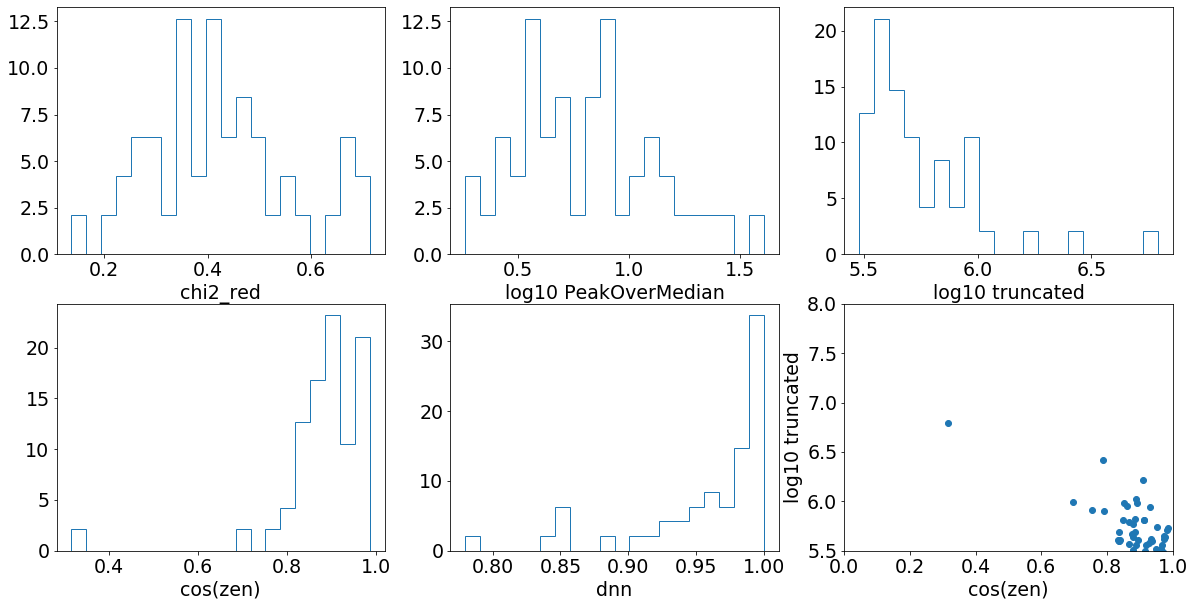

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.hist(chi2_red_data_sig,weights=weight_data_sig,bins=20,histtype='step')
plt.xlabel('chi2_red')
plt.subplot(232)
plt.hist(np.log10(PeakOverMedian_data_sig),weights=weight_data_sig,bins=20,histtype='step')
plt.xlabel('log10 PeakOverMedian')
plt.subplot(233)
plt.hist(np.log10(truncated_muon_e_data_sig),weights=weight_data_sig,bins=20,histtype='step')
plt.xlabel('log10 truncated')
plt.subplot(234)
plt.hist(np.cos(zenith_data_sig),weights=weight_data_sig,bins=20,histtype='step')
plt.xlabel('cos(zen)')
plt.subplot(235)
plt.hist(signal_dnn_data_sig,weights=weight_data_sig,bins=20,histtype='step')
plt.xlabel('dnn')
plt.subplot(236)
plt.scatter(np.cos(zenith_data_sig),np.log10(truncated_muon_e_data_sig))
plt.xlim(0,1)
plt.ylim(5.5,8)
plt.xlabel('cos(zen)')
plt.ylabel('log10 truncated')
plt.show()

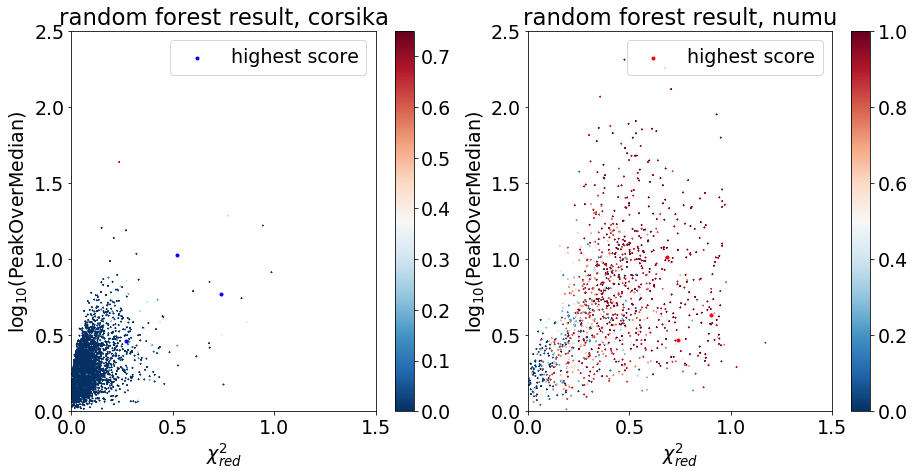

In [155]:
# ----- PeakOverMedian vs chi2_red ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,0][y_test==0][::40],X_test[:,1][y_test==0][::40],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,1][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score')
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,0][y_test==1][::2],X_test[:,1][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,1][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_pom_chi2_small_ineff.png',dpi=600)
plt.show()

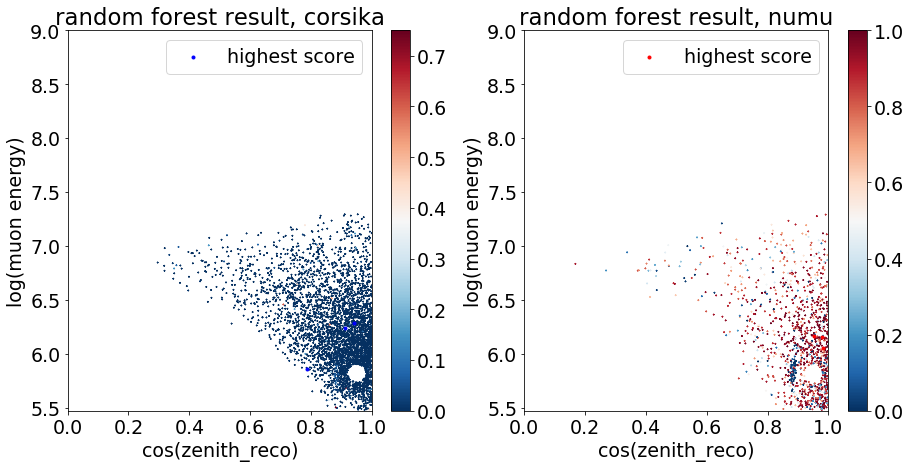

In [156]:
# ----- energy vs zenith ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,2][y_test==0][::40],X_test[:,3][y_test==0][::40],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,3][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score') 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,2][y_test==1][::2],X_test[:,3][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,3][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_energy_zenith_small_ineff.png',dpi=600)
plt.show()

In [19]:
#### ------------------- focus on ineff low region first (above) -------------------
# ------------------- ------------------- ------------------- -------------------
# ------------------- ------------------- ------------------- -------------------
# ------------------- ------------------- ------------------- -------------------
# ------------------- ------------------- ------------------- -------------------

<font color ='darkorange'><font size = 6> 0) Global, not ineff cuts

In [7]:
radius = 2.
coszencut = 0.2

# optimum: 
# radius = 2.
# coszencut = 0.2

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 72701 # with _rf, the size of broken file is 266K instead of 0! 

    CUT_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    CUT_P1 = (np.cos(CUT_zenith) >= coszencut) & (np.log10(CUT_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_zenith) - pcut3)/pcut4)**2 ))
    CUT_P2 = (np.cos(CUT_zenith) < coszencut)
    CUT_phase = np.any([CUT_P1, CUT_P2],axis=0)
    bsize_corsika = f.root.Bundle_Size.cols.value[:]

#     CUT = np.ones(len(CUT_zenith),dtype='bool')
    CUT_bundle = f.root.Bundle_Size.cols.value[:] > 1 # only use muon bundles!
    CUT = CUT_phase & CUT_bundle    
    
    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    ndf_corsika = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_corsika = chi2_corsika/ndf_corsika
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_corsika = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file


with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 18989

    CUT_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    CUT_P1 = (np.cos(CUT_zenith) >= coszencut) & (np.log10(CUT_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_zenith) - pcut3)/pcut4)**2 ))
    CUT_P2 = (np.cos(CUT_zenith) < coszencut) 
    CUT_phase = np.any([CUT_P1, CUT_P2],axis=0)
    bsize_numu = f.root.Bundle_Size.cols.value[:]
#     CUT = np.ones(len(CUT_zenith),dtype='bool')
    CUT = CUT_phase
    
    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    ndf_numu = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_numu = chi2_numu/ndf_numu    
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_numu = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2813559.84254, 2955469.73138, 3052686.52963, 3240653.63454, 2919677.64478]  # _gaps.txt; 2012, 2013, 2014, 2015, 2016

    CUT_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    CUT_P1 = (np.cos(CUT_zenith) >= coszencut) & (np.log10(CUT_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_zenith) - pcut3)/pcut4)**2 ))
    CUT_P2 = (np.cos(CUT_zenith) < coszencut) 
    CUT_phase = np.any([CUT_P1, CUT_P2],axis=0)

#     CUT = np.ones(len(CUT_zenith),dtype='bool')
    CUT = CUT_phase
    
    chi2_data = f.root.Collection.cols.chi2[:][CUT]
    ndf_data = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_data = chi2_data/ndf_data    
    PeakOverMedian_data = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_data = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_data = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    
    signal_dnn_data = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(signal_dnn_data))

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  after removing the cwd from sys.path.


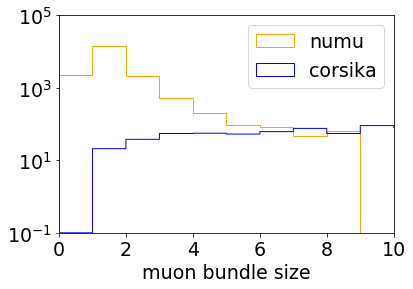

In [8]:
plt.hist(bsize_numu,bins=np.arange(0,10,1),color='orange',histtype='step',log=True,label='numu')
plt.hist(bsize_corsika,bins=np.arange(0,1000,1),color='blue',histtype='step',log='True',label='corsika')
plt.xlim(0,10)
plt.ylim(0,10**5)
plt.xlabel('muon bundle size')
plt.legend()
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'lw'


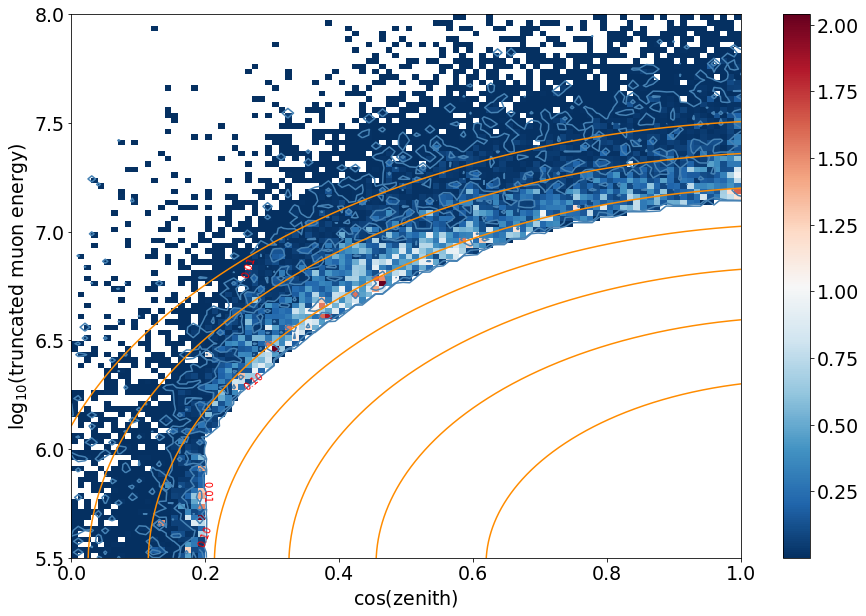

In [9]:
# ----- transform phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(15,10))
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.001)
plt.colorbar()

# far region 
p1 = 5.47 # y center
p2 = 1.2
p3 = 1.1 # x center
p4 = 0.68

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.5,3,0.4)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'-',color='darkorange')

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.1,1,10,30,50,100,200,300,400,500,1000],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.savefig(fig_dir + 'rf_contour_full.png',dpi=600)
plt.show()

In [10]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),7  ))

X[:,0] = np.concatenate((chi2_red_corsika,chi2_red_numu))
X[:,1] = np.concatenate((np.log10(PeakOverMedian_corsika),np.log10(PeakOverMedian_numu))) 
X[:,2] = np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu)))
X[:,3] = np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu)))
X[:,4] = np.concatenate(( (np.log10(truncated_muon_e_corsika)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_corsika)-pcut3)**2/pcut4**2,
                          (np.log10(truncated_muon_e_numu)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_numu)-pcut3)**2/pcut4**2  ))

X[:,5] = np.concatenate((signal_dnn_corsika,signal_dnn_numu))
X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

# COV = np.cov(X[:,:-2].T)

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5,random_state=20)
weights_train = X_train[:,-1] * 2 # NEED TO CHECK!!! 
weights_test = X_test[:,-1] * 2 # NEED TO CHECK!!! 
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
n_estimators = 500

clf = RandomForestClassifier(n_estimators=n_estimators,n_jobs=4)
# from sklearn.ensemble import AdaBoostClassifier
# clf = AdaBoostClassifier(n_estimators=100)

clf.fit(X_train, y_train)

# _ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/full_region.pkl', compress = 9,protocol=2)
_=pickle.dump(clf, open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/full_region.pkl','wb'),protocol=2)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/full_region.pkl'>


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


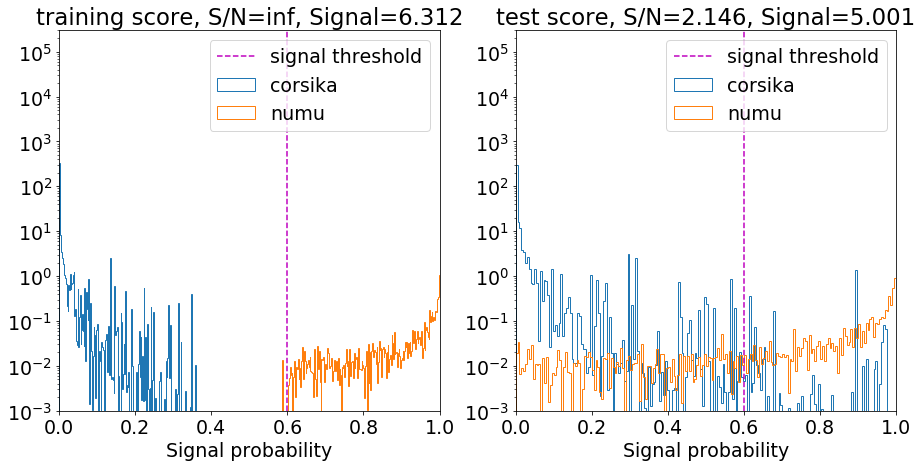

In [11]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=200,histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=200,histtype='step',label='numu',log=True,bottom=10**(-6))

plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=200,histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=200,histtype='step',label='numu',log=True,bottom=10**(-6))

plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
plt.savefig(fig_dir + 'rf_score_full.png',dpi=600)
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


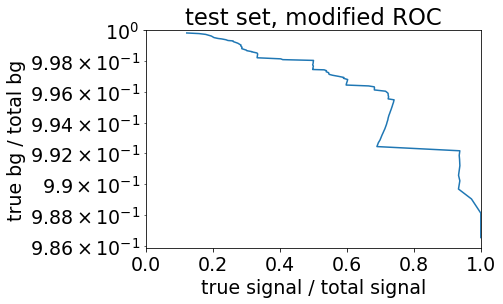

In [12]:
# ROC curve? 
sig_ratio = []
bg_ratio = []
for t in np.arange(0,1,0.01):
    numu_above = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1]) > t] )
    total_above = np.sum( weights_test[probability_test > t] )
    corsika_below = np.sum( (weights_test[y_test==0])[(probability_test[y_test==0]) < t] )
    total_below = np.sum( weights_test[probability_test < t] )
    sig_ratio = np.append(sig_ratio, numu_above/total_above)
    bg_ratio = np.append(bg_ratio, corsika_below/total_below)

plt.figure()
plt.semilogy(sig_ratio, bg_ratio)
plt.xlabel('true signal / total signal')
plt.ylabel('true bg / total bg')
plt.title('test set, modified ROC')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


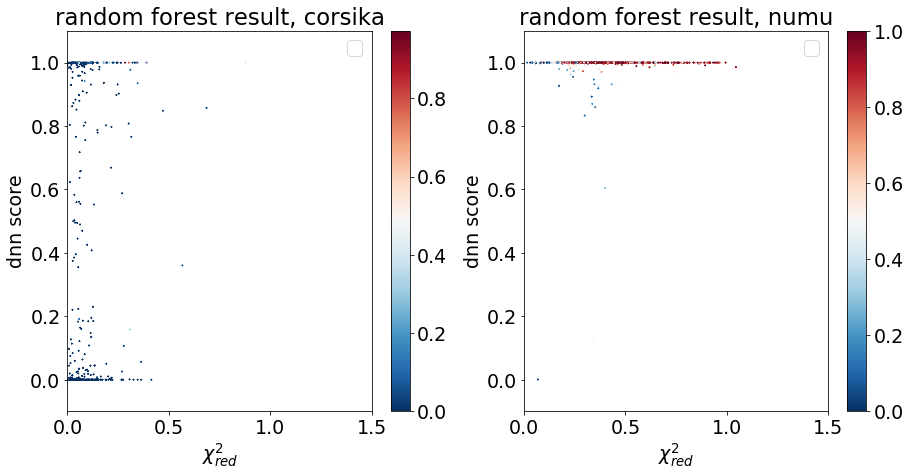

In [13]:
# ----- dnn score vs chi2_red ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,0][y_test==0][::40],X_test[:,5][y_test==0][::40],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'dnn score')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(-0.1,1.1)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,0][y_test==1][::2],X_test[:,5][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'dnn score')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(-0.1,1.1)
plt.title('random forest result, numu')
# plt.savefig(fig_dir + 'rf_pom_chi2_full.pdf')
# plt.savefig(fig_dir + 'rf_pom_chi2_full.png')
plt.show()

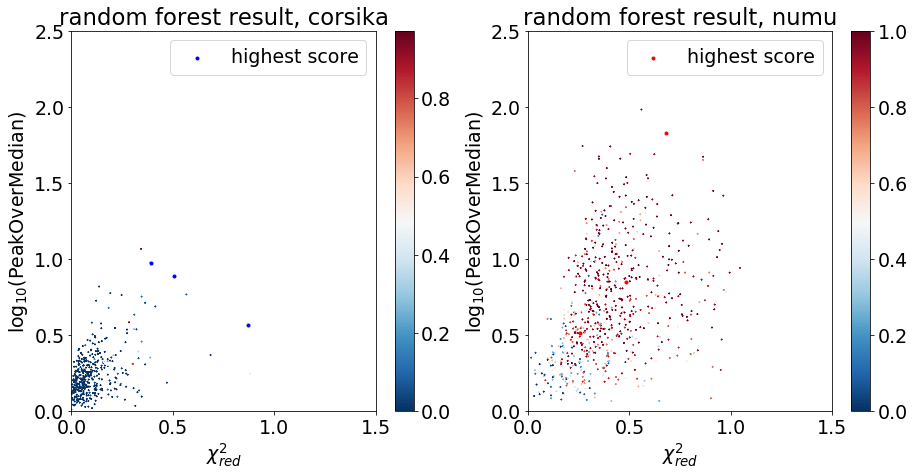

In [14]:
# ----- PeakOverMedian vs chi2_red ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,0][y_test==0][::40],X_test[:,1][y_test==0][::40],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,1][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score')
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,0][y_test==1][::2],X_test[:,1][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,1][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_pom_chi2_full.png',dpi=600)
plt.show()

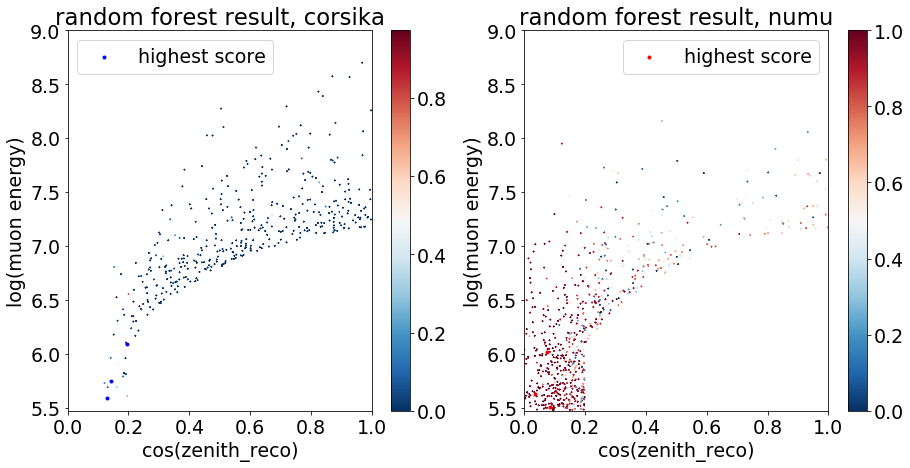

In [15]:
# ----- energy vs zenith ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,2][y_test==0][::40],X_test[:,3][y_test==0][::40],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,3][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score') 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,2][y_test==1][::2],X_test[:,3][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,3][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_energy_zenith_full.png',dpi=600)
plt.show()

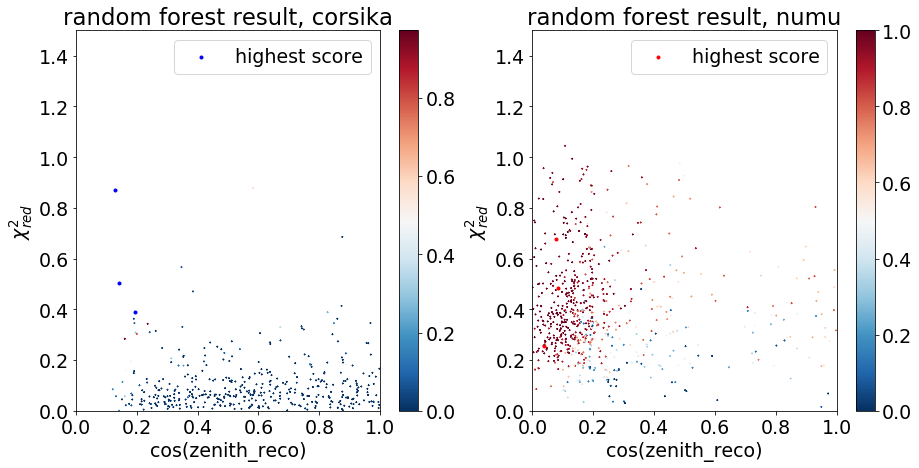

In [16]:
# ----- chi2_red vs zenith ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,2][y_test==0][::40],X_test[:,0][y_test==0][::40],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,0][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score')
plt.xlabel('cos(zenith_reco)')
plt.ylabel(r'$\chi^2_{red}$')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1.5)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,2][y_test==1][::2],X_test[:,0][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,0][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel('cos(zenith_reco)')
plt.ylabel(r'$\chi^2_{red}$')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1.5)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_chi2_zenith_full.png',dpi=600)
plt.show()

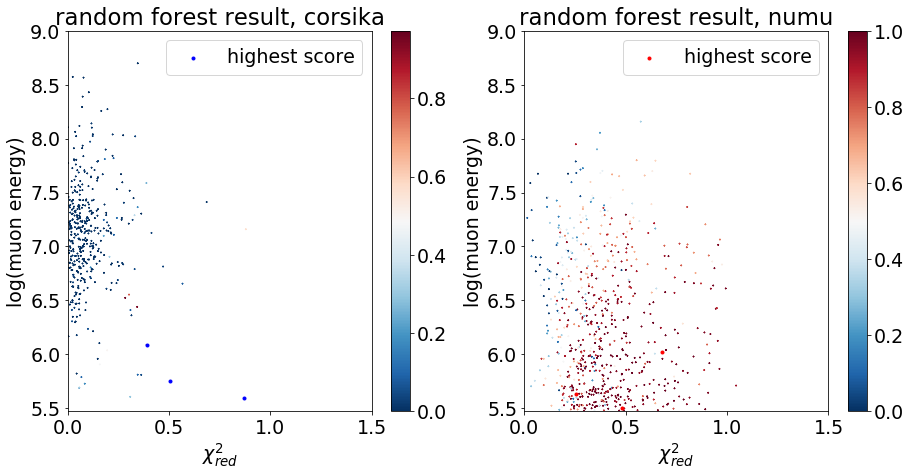

In [17]:
# ----- energy vs chi2_red ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,0][y_test==0][::40],X_test[:,3][y_test==0][::40],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,3][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score')
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(5.47,9.)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,0][y_test==1][::2],X_test[:,3][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,3][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(5.47,9.)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_energy_chi2_full.png',dpi=600)
plt.show()

<font color ='darkorange'><font size = 6> 2) Horizontal Region, cos(zenith),E $\in$  ?

In [28]:
def proplen(E): # in GeV. return distance in ice (m) that 99.9% of muons are eliminated. 
    a = 0.212/1.2
    b = 0.251*10**(-3)/1.2
    return np.log(1+E*b/a)/b / 0.9 # convert mwe to ice, divide by density of ice
proplen(300000)

31210.946020359985

In [29]:
icecap_cut = 0.15

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 72701 # with _rf, the size of broken file is 266K instead of 0! 
    
    CUT_icecap = np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]) < icecap_cut
    CUT = CUT_icecap

    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    ndf_corsika = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_corsika = chi2_corsika/ndf_corsika
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_corsika = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]

    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file


with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 18989

    CUT_icecap = np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]) < icecap_cut
    CUT = CUT_icecap

    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    ndf_numu = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_numu = chi2_numu/ndf_numu    
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_numu = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()


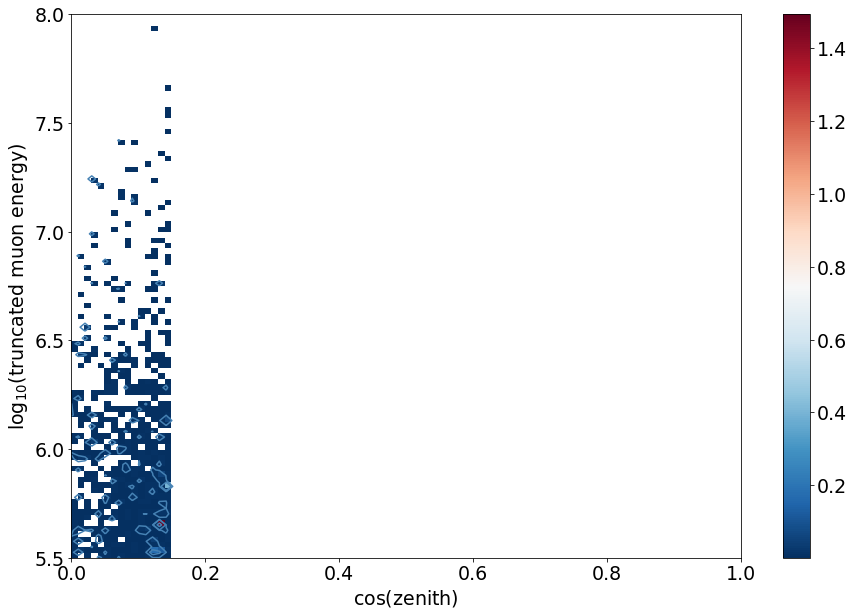

In [30]:
# ----- transform phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(15,10))
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.001)
plt.colorbar()

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.1,1,10,30,50,100,200,300,400,500,1000],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.savefig(fig_dir + 'rf_contour_horizontal.png',dpi=600)
plt.show()

In [31]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),7  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((chi2_red_corsika,chi2_red_numu))
X[:,1] = np.concatenate((np.log10(PeakOverMedian_corsika),np.log10(PeakOverMedian_numu))) 
X[:,2] = np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu)))
X[:,3] = np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu)))
X[:,4] = np.concatenate(( (np.log10(truncated_muon_e_corsika)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_corsika)-pcut3)**2/pcut4**2,
                          (np.log10(truncated_muon_e_numu)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_numu)-pcut3)**2/pcut4**2  ))

X[:,5] = np.concatenate((signal_dnn_corsika,signal_dnn_numu))
X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5,random_state=1)
weights_train = X_train[:,-1] * 2
weights_test = X_test[:,-1] * 2
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

clf = RandomForestClassifier(n_estimators=500,n_jobs=4)

clf.fit(X_train, y_train)
_ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/horizontal_region.pkl', compress = 9)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


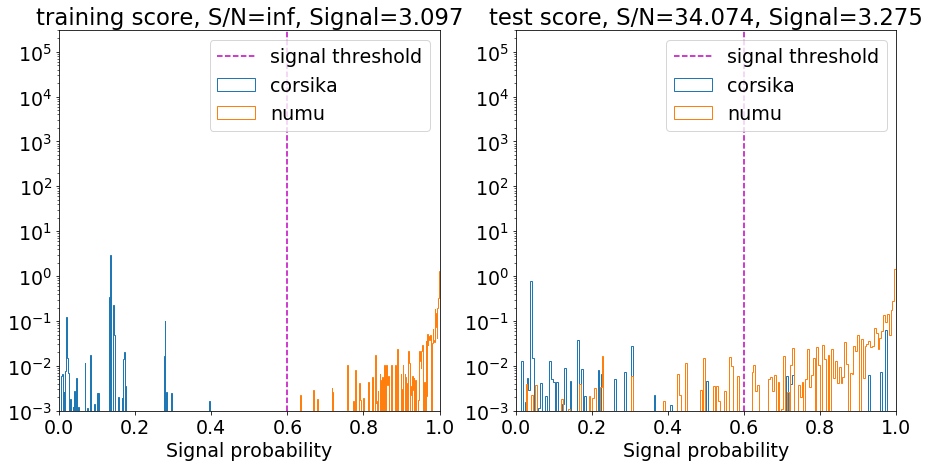

In [32]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=200,histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=200,histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=200,histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=200,histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
plt.savefig(fig_dir + 'rf_score_horizontal.png',dpi=600)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


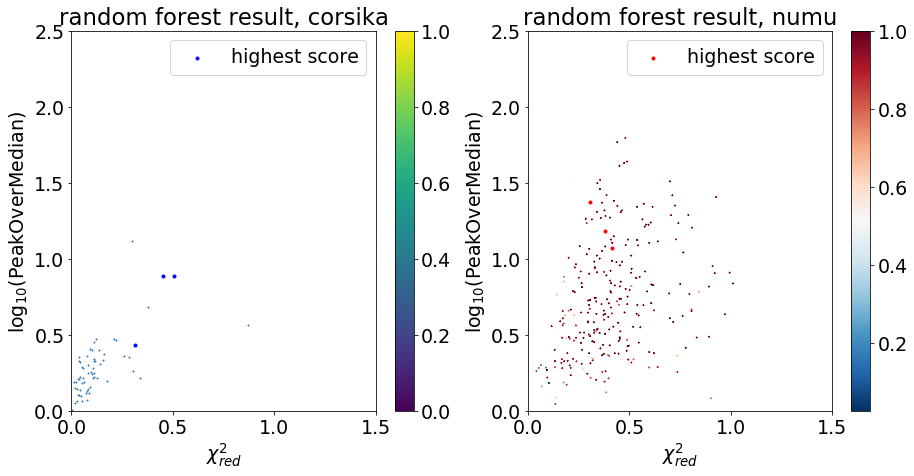

In [33]:
# ----- PeakOverMedian vs chi2_red ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,0][y_test==0][::2],X_test[:,1][y_test==0][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,1][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score')
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,0][y_test==1][::2],X_test[:,1][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,1][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_pom_chi2_horizontal.png',dpi=600)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


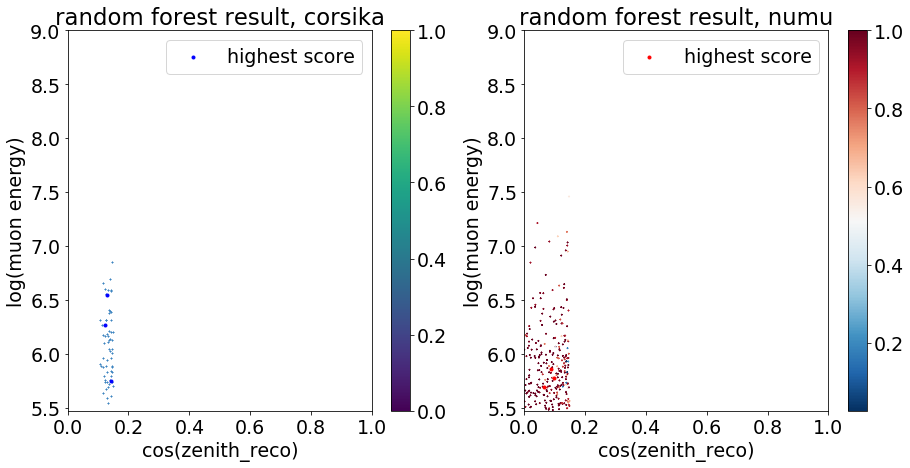

In [34]:
# ----- energy vs zenith ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,2][y_test==0][::2],X_test[:,3][y_test==0][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,3][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score') 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,2][y_test==1][::2],X_test[:,3][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,3][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_energy_zenith_horizontal.png',dpi=600)
plt.show()

<font color ='darkorange'><font size = 6> 3) Intermediate region: coszen > ? & ineff > 0.01

In [35]:
pcut1 = 5.47 # y center
pcut2 = 1.4
pcut3 = 0.65 # x center
pcut4 = 0.6

IT_ineff_cut = 0.01
icecap_cut = 0.15
 
radius = 0.62
coszencut = 0.26

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 72701 # with _rf, the size of broken file is 266K instead of 0! 
    
    ineff_corsika = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika > IT_ineff_cut
    
    CUT_icecap = np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]) > icecap_cut

    CUT_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    CUT_P1 = (np.cos(CUT_zenith) >= coszencut) & (np.log10(CUT_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_zenith) - pcut3)/pcut4)**2 ))
    CUT_P2 = (np.cos(CUT_zenith) < coszencut) 
    CUT_phase = np.any([CUT_P1, CUT_P2],axis=0)

#     CUT = np.ones(len(CUT_zenith),dtype='bool')
#     CUT = CUT_ineff
#     CUT = CUT_ineff & CUT_icecap
    CUT = CUT_ineff & CUT_icecap & CUT_phase

    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    ndf_corsika = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_corsika = chi2_corsika/ndf_corsika
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_corsika = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]

    dist_corsika = f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:][CUT]
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 


with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 18989

    ineff_numu = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_numu > IT_ineff_cut

    CUT_icecap = np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]) > icecap_cut

    CUT_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    CUT_P1 = (np.cos(CUT_zenith) >= coszencut) & (np.log10(CUT_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_zenith) - pcut3)/pcut4)**2 ))
    CUT_P2 = (np.cos(CUT_zenith) < coszencut) 
    CUT_phase = np.any([CUT_P1, CUT_P2],axis=0)

#     CUT = np.ones(len(CUT_zenith),dtype='bool')
#     CUT = CUT_ineff
#     CUT = CUT_ineff & CUT_icecap
    CUT = CUT_ineff & CUT_icecap & CUT_phase

    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    ndf_numu = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_numu = chi2_numu/ndf_numu    
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_numu = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'lw'


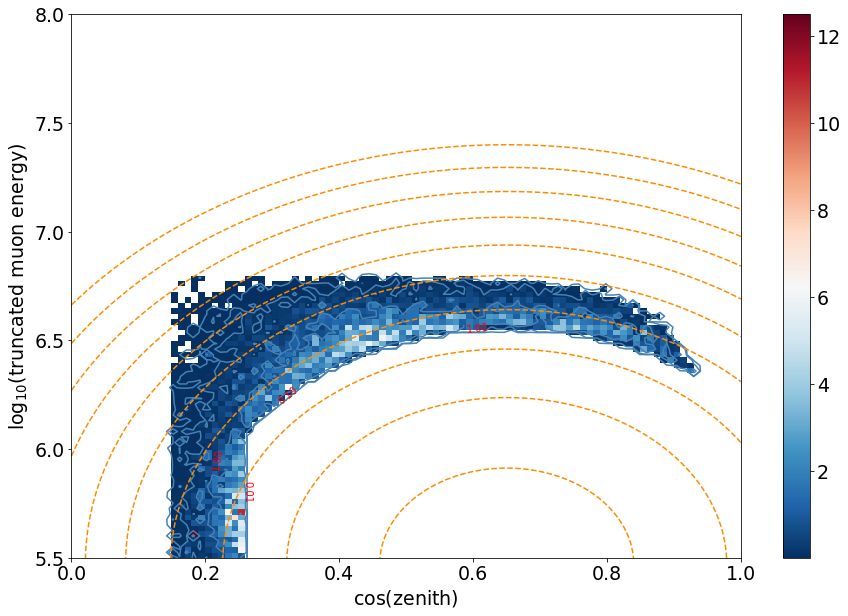

In [36]:
# ----- transform phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(15,10))
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.001)
plt.colorbar()

# near region 
p1 = 5.47 # y center
p2 = 1.4
p3 = 0.65 # x center
p4 = 0.6

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.1,2,0.2)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'--',color='darkorange')

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.1,1,10,30,50,100,200,300,400,500,600],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.savefig(fig_dir + 'rf_contour_intermediate.png',dpi=600)
plt.show()

In [37]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),7  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((chi2_red_corsika,chi2_red_numu))
X[:,1] = np.concatenate((np.log10(PeakOverMedian_corsika),np.log10(PeakOverMedian_numu))) 
X[:,2] = np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu)))
X[:,3] = np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu)))
X[:,4] = np.concatenate(( (np.log10(truncated_muon_e_corsika)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_corsika)-pcut3)**2/pcut4**2,
                          (np.log10(truncated_muon_e_numu)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_numu)-pcut3)**2/pcut4**2  ))

X[:,5] = np.concatenate((signal_dnn_corsika,signal_dnn_numu))
X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5,random_state=1)
weights_train = X_train[:,-1] * 2 
weights_test = X_test[:,-1] * 2
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
clf = RandomForestClassifier(n_estimators=500,n_jobs=4)

clf.fit(X_train, y_train)
_ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/intermediate_region.pkl', compress = 9)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


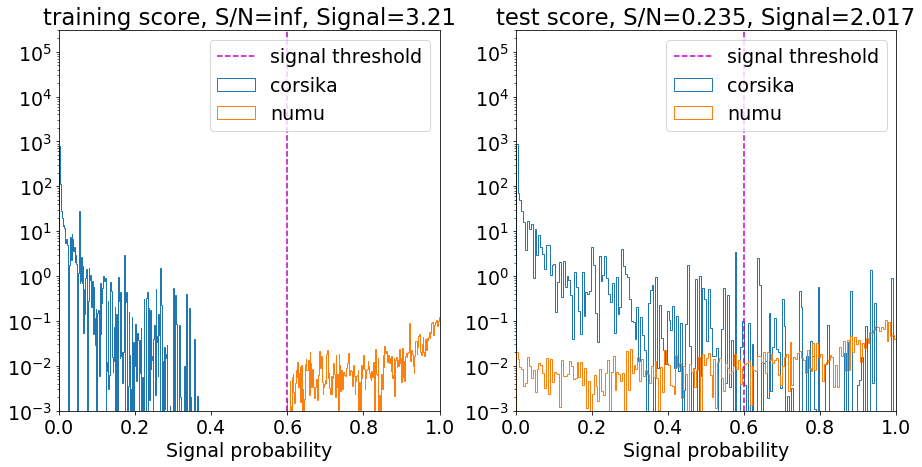

In [38]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=200,histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=200,histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=200,histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=200,histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
plt.savefig(fig_dir + 'rf_score_intermediate.png',dpi=600)
plt.show()

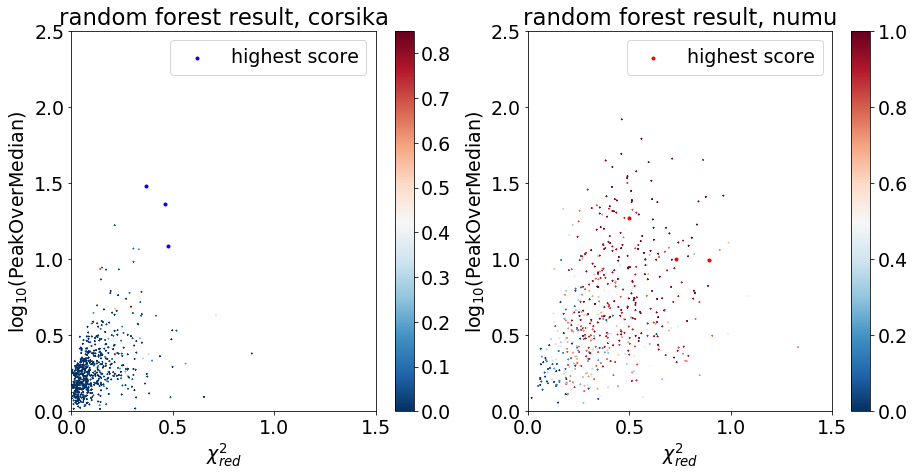

In [39]:
# ----- PeakOverMedian vs chi2_red ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,0][y_test==0][::20],X_test[:,1][y_test==0][::20],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::20],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,1][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score')
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,0][y_test==1][::2],X_test[:,1][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,0][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,1][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_pom_chi2_intermediate.png',dpi=600)
plt.show()

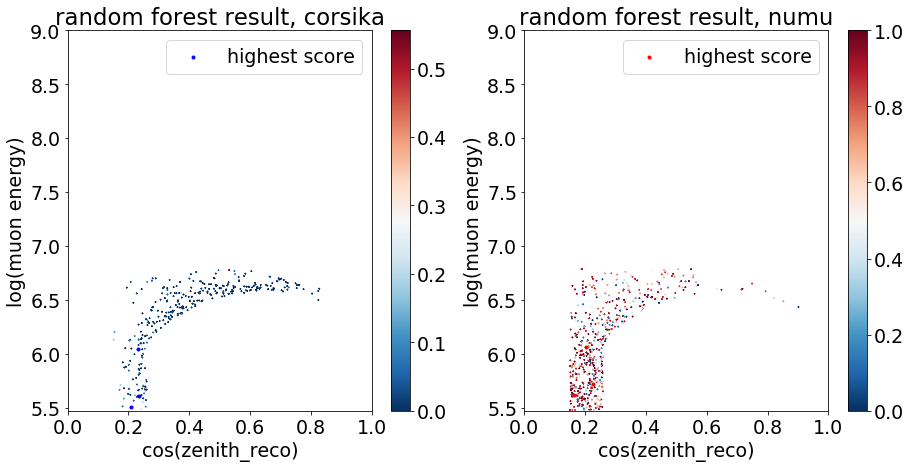

In [40]:
# ----- energy vs zenith ----- 

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(X_test[:,2][y_test==0][::40],X_test[:,3][y_test==0][::40],marker='x',s=1,alpha=1,c=probability_test[y_test==0][::40],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],(X_test[:,3][y_test==0])[(probability_test[y_test==0]).argsort()[::-1]][:3],marker='.',alpha=1,c='blue',label='highest score') 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('random forest result, corsika')
plt.subplot(122)
plt.scatter(X_test[:,2][y_test==1][::2],X_test[:,3][y_test==1][::2],marker='x',s=1,alpha=1,c=probability_test[y_test==1][::2],cmap='RdBu_r') 
plt.colorbar()
plt.scatter((X_test[:,2][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],(X_test[:,3][y_test==1])[(probability_test[y_test==1]).argsort()[::-1]][:3],marker='.',alpha=1,c='red',label='highest score') 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.legend()
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'rf_energy_zenith_intermediate.png',dpi=600)
plt.show()